# Analisis Sentimen Debat Capres 2024
Table of Contents:
1. Data Scraping
2. Load Scraped Data
3. Cleaning Data
4. Pre-processing
5. Translate
6. Labelling
7. Visualization
8. Modelling
9. Evaluation

In [3]:
!pip install -q Sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 2.1 MB/s eta 0:00:00


In [4]:
from googleapiclient.discovery import build
from nltk import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn import pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import string
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Scraping

[LIVE] Debat Capres 2024, Nobar Debat Ronde Ketiga di Musyawarah | Musyawarah: <br>
https://www.youtube.com/live/Sbjsg3AFx00?si=VH1y1B9fO2DkGsYL

In [427]:
file_path = "/content/drive/MyDrive/Colab Notebooks/Sentimen Debat Capres/yt_api.txt"

with open(file_path, 'r') as file:
    # Read the entire content of the file
    YT_API = file.read()

In [432]:
YT_URL = 'https://www.youtube.com/watch?v=Sbjsg3AFx00&ab_channel=NajwaShihab'

In [433]:
api_key = YT_API
youtube = build("youtube","v3", developerKey=api_key)
url = YT_URL

def get_comments(url):
    # Get the ID of the video by splitting the URL
    single_video_id = url.split("=")[1].split("&")[0]
    # Use the list() method to extract a JSON with key information
    # from the video.
    video_list=youtube.videos().list(part="snippet",id=single_video_id).execute()
    channel_id= video_list["items"][0]["snippet"]["channelId"]
    title_single_video= video_list["items"][0]["snippet"]["title"]
    playlist_id = None
    forUserName = None

    nextPageToken_comments = None
    commentsone=[]

    while True:
        #Request the first 50 videos of a channel. This is the full dictionary. The result is store in a variable called "pl_response".
        #PageToken at this point is "None"
        pl_request_comment= youtube.commentThreads().list(part=["snippet","replies"],
                                            videoId=single_video_id,
                                            maxResults=50,
                                            pageToken= nextPageToken_comments)
        pl_response_comment = pl_request_comment.execute()

        ## Send the amount of views and the URL of each video to the videos empty list that was declared at the beginning of the code.
        for i in pl_response_comment["items"]:
            vid_comments = i["snippet"]["topLevelComment"]["snippet"]["textOriginal"]
            comm_author = i["snippet"]["topLevelComment"]["snippet"]["authorDisplayName"]
            comm_author_id = i["snippet"]["topLevelComment"]["snippet"]["authorChannelId"]["value"]
            comm_date = i["snippet"]["topLevelComment"]["snippet"]["publishedAt"]
            comm_likes = i["snippet"]["topLevelComment"]["snippet"]["likeCount"]
            new_var=i.get("replies","0")

            commentsone.append({
                "comm_date":comm_date,
                "author":comm_author,
                "author_id":comm_author_id,
                "likes":comm_likes,
                "comment":vid_comments,
                "video_id":single_video_id
            })

        nextPageToken_comments = pl_response_comment.get("nextPageToken")

        if not nextPageToken_comments:
            break

    for i in commentsone[:10]:
        print(i["comment"])

    pd.DataFrame.from_dict(commentsone).to_csv("/content/drive/MyDrive/Colab Notebooks/Sentimen Debat Capres/dataset.csv", index=False)

get_comments(url)

ya saya setuju saya tunggu , kak najwa undang mreka bertiga capres kita , sematkan link data digital mreka bertiga untuk di akses oleh kami rakyat milenial cinta tanah air generasi yg akan datang di kolom komentar. terimakasih.
Prabowo yess
maju terus pak ganjar.Pak anis blm  paham di pemerintahan.Anis tdk bisa kerja
Najwa sudah ga tajam nih
Indonesia pernah menjadi negara yg bermartabat dan disegani di Asia dan keamanan stabil jarang ada pembunuhan" sadis.  Cuma 1x, yaitu wkt presidennya mantan militer !
Semangat pak prabowo👍👍👍👍
Tidak peduli mau paling muda atau tua untuk nyata orang lebih tua lebih baik berkata jujur berani menyatakan realita tidak hanya omongan saja untuk prabowo kepancing atau ga kepancing tetep konsisten memberi kalimat dalam kata2 semangat pak prabowo 'all in prabowo gibran'
Si ajig lagi mancing emosi bapa kita prabowo subianto
prabowo gaseru baperan,,lain x gausah diajak ,,konciin ditoilet,,gausah diajak debat,,ganti am wakilny pa ,mahfud lebih ,,meriah,,,lwbih 

# Load Scraped Data

In [434]:
df_ori = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Sentimen Debat Capres/dataset.csv")
df_ori.head()

,comm_date,author,author_id,likes,comment,video_id
0,2024-01-08T17:44:27Z,@user-hq9um7dw2l,UCcdA5yghK20tMmoVIzAugwQ,0,"ya saya setuju saya tunggu , kak najwa undang ...",Sbjsg3AFx00
1,2024-01-08T17:43:47Z,@vivoopoo22,UCbMDZo5DcPvprCi2_4iBX_A,0,Prabowo yess,Sbjsg3AFx00
2,2024-01-08T17:41:36Z,@andydarwis1178,UCsXxL-N5w9iPrXlkkAvJj7Q,0,maju terus pak ganjar.Pak anis blm paham di p...,Sbjsg3AFx00
3,2024-01-08T17:39:34Z,@user-rh3sn1tf4r,UCUNQ-0SbyiZYDUyjCYchmoQ,0,Najwa sudah ga tajam nih,Sbjsg3AFx00
4,2024-01-08T17:38:52Z,@herubambang115,UC7XuS3cwyJmZ9YVyF6-5eZw,0,Indonesia pernah menjadi negara yg bermartabat...,Sbjsg3AFx00


In [435]:
df_ori.count()

comm_date    3597
author       3597
author_id    3597
likes        3597
comment      3597
video_id     3597
dtype: int64

# Cleaning Data

In [256]:
df_new = df_ori[['comment']]
df_new.head()

,comment
0,Knpa mata najwa gk tayang lg di tv ..padahal s...
1,"Soal atik,MK YG lulus kan ank kecil jdi presid..."
2,Capres omdo pintar bicara tidak ada bukti 😂 pa...
3,☝
4,Salfok sama sesi terahir saat wartawan ingin b...


## Drop duplicates

In [257]:
df_new.duplicated().sum()

90

In [258]:
df_new[df_new.duplicated()]

,comment
97,"Panjang umur, sehat selalu dan semoga di lindu..."
98,"Panjang umur, sehat selalu dan semoga di lindu..."
99,"Panjang umur, sehat selalu dan semoga di lindu..."
100,"Panjang umur, sehat selalu dan semoga di lindu..."
156,Wkwk endingnya ada yang pundung gamau jabat ta...
...,...
3110,01
3172,02
3185,Prabowo ❤
3213,Amin 01


In [259]:
df_new = df_new.drop_duplicates()

In [260]:
df_new.duplicated().sum()

0

## Drop Missing Values

In [261]:
df_new.isnull().sum()

comment    0
dtype: int64

# Pre-processing

In [13]:
def caseFolding(comment):
    comment = comment.lower()
    comment = comment.strip(" ")
    comment = re.sub(r'[?|$|.|!]',r'', comment)
    comment = re.sub(r'[^a-zA-Z ]', r'', comment)
    return comment

In [263]:
df_new['casefolded_comment'] = df_new['comment'].apply(caseFolding)
df_new

,comment,casefolded_comment
0,Knpa mata najwa gk tayang lg di tv ..padahal s...,knpa mata najwa gk tayang lg di tv padahal sng...
1,"Soal atik,MK YG lulus kan ank kecil jdi presid...",soal atikmk yg lulus kan ank kecil jdi preside...
2,Capres omdo pintar bicara tidak ada bukti 😂 pa...,capres omdo pintar bicara tidak ada bukti pan...
3,☝,
4,Salfok sama sesi terahir saat wartawan ingin b...,salfok sama sesi terahir saat wartawan ingin b...
...,...,...
3237,🤟🏻🤟🏻🤟🏻,
3238,Debat kedua Capres ini seruu bangetttt🔥🔥🔥🔥,debat kedua capres ini seruu bangetttt
3239,Bismillah 😊,bismillah
3241,"1 FOREVER, 2-3 no more...!!! AM1N!!!",forever no more amn


## Check Missing Values

In [264]:
df_hapus = df_new[~df_new['casefolded_comment'].str.contains(" ")]
df_new = df_new[~df_new.isin(df_hapus)].dropna()

In [265]:
df_new.to_csv('/content/drive/MyDrive/Colab Notebooks/Sentimen Debat Capres/casefolded_dataset.csv', index=False)

## Tokenization

In [266]:
def word_tokenize_wrapper(x):
    return word_tokenize(x)

In [267]:
df_new['tokens'] = df_new['casefolded_comment'].apply(word_tokenize_wrapper)
df_new

,comment,casefolded_comment,tokens
0,Knpa mata najwa gk tayang lg di tv ..padahal s...,knpa mata najwa gk tayang lg di tv padahal sng...,"[knpa, mata, najwa, gk, tayang, lg, di, tv, pa..."
1,"Soal atik,MK YG lulus kan ank kecil jdi presid...",soal atikmk yg lulus kan ank kecil jdi preside...,"[soal, atikmk, yg, lulus, kan, ank, kecil, jdi..."
2,Capres omdo pintar bicara tidak ada bukti 😂 pa...,capres omdo pintar bicara tidak ada bukti pan...,"[capres, omdo, pintar, bicara, tidak, ada, buk..."
4,Salfok sama sesi terahir saat wartawan ingin b...,salfok sama sesi terahir saat wartawan ingin b...,"[salfok, sama, sesi, terahir, saat, wartawan, ..."
5,"mbak nana mulai jaga bicara kayaknya nih, agak...",mbak nana mulai jaga bicara kayaknya nih agak ...,"[mbak, nana, mulai, jaga, bicara, kayaknya, ni..."
...,...,...,...
3236,Salam 2 jari... prabowo gibran menang satu put...,salam jari prabowo gibran menang satu putaran...,"[salam, jari, prabowo, gibran, menang, satu, p..."
3238,Debat kedua Capres ini seruu bangetttt🔥🔥🔥🔥,debat kedua capres ini seruu bangetttt,"[debat, kedua, capres, ini, seruu, bangetttt]"
3239,Bismillah 😊,bismillah,[bismillah]
3241,"1 FOREVER, 2-3 no more...!!! AM1N!!!",forever no more amn,"[forever, no, more, amn]"


## Slang Normalization

In [6]:
file_path = "/content/drive/MyDrive/Colab Notebooks/Sentimen Debat Capres/sheet_id.txt"

with open(file_path, 'r') as file:
    # Read the entire content of the file
    sheet_id = file.read()

In [7]:
normalized_word = pd.read_csv(f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv")

normalized_word_dict = {}
for index, row in normalized_word.iterrows():
    if row[0] not in normalized_word_dict:
        normalized_word_dict[row[0]] = row[1]

In [270]:
def normalized_term(document):
    return [normalized_word_dict[term] if term in normalized_word_dict else term for term in document]

In [271]:
df_new['fixed_tokens'] = df_new['tokens'].apply(normalized_term)
df_new

,comment,casefolded_comment,tokens,fixed_tokens
0,Knpa mata najwa gk tayang lg di tv ..padahal s...,knpa mata najwa gk tayang lg di tv padahal sng...,"[knpa, mata, najwa, gk, tayang, lg, di, tv, pa...","[kenapa, mata, najwa, tidak, tayang, lagi, di,..."
1,"Soal atik,MK YG lulus kan ank kecil jdi presid...",soal atikmk yg lulus kan ank kecil jdi preside...,"[soal, atikmk, yg, lulus, kan, ank, kecil, jdi...","[soal, atikmk, yang, lulus, kan, anak, kecil, ..."
2,Capres omdo pintar bicara tidak ada bukti 😂 pa...,capres omdo pintar bicara tidak ada bukti pan...,"[capres, omdo, pintar, bicara, tidak, ada, buk...","[capres, wacana, pintar, bicara, tidak, ada, b..."
4,Salfok sama sesi terahir saat wartawan ingin b...,salfok sama sesi terahir saat wartawan ingin b...,"[salfok, sama, sesi, terahir, saat, wartawan, ...","[salfok, sama, sesi, terakhir, saat, wartawan,..."
5,"mbak nana mulai jaga bicara kayaknya nih, agak...",mbak nana mulai jaga bicara kayaknya nih agak ...,"[mbak, nana, mulai, jaga, bicara, kayaknya, ni...","[mbak, nana, mulai, jaga, bicara, kayaknya, in..."
...,...,...,...,...
3236,Salam 2 jari... prabowo gibran menang satu put...,salam jari prabowo gibran menang satu putaran...,"[salam, jari, prabowo, gibran, menang, satu, p...","[salam, jari, prabowo, gibran, menang, satu, p..."
3238,Debat kedua Capres ini seruu bangetttt🔥🔥🔥🔥,debat kedua capres ini seruu bangetttt,"[debat, kedua, capres, ini, seruu, bangetttt]","[debat, kedua, capres, ini, seruu, bangetttt]"
3239,Bismillah 😊,bismillah,[bismillah],[bismillah]
3241,"1 FOREVER, 2-3 no more...!!! AM1N!!!",forever no more amn,"[forever, no, more, amn]","[forever, no, more, amn]"


In [272]:
df_new.to_csv('/content/drive/MyDrive/Colab Notebooks/Sentimen Debat Capres/tokenized_dataset.csv', index=False)

## Stopword

In [247]:
# nltk.download("stopwords")

In [248]:
# stopword = nltk.corpus.stopwords.words('indonesian')

# def remove_stopwords(text):
#   text = [word for word in text if word not in stopword]
#   return text

In [249]:
# df_new['stop_removal'] = df_new['fixed_tokens'].apply(lambda x: remove_stopwords(x))
# df_new

## Final Comments

In [273]:
final_string_tokens = []
for text in df_new['fixed_tokens'].values:
    EachReviewText = ""
    EachReviewText = ' '.join(text)
    final_string_tokens.append(EachReviewText)

In [274]:
df_new["final_comment"] = final_string_tokens
df_new

,comment,casefolded_comment,tokens,fixed_tokens,final_comment
0,Knpa mata najwa gk tayang lg di tv ..padahal s...,knpa mata najwa gk tayang lg di tv padahal sng...,"[knpa, mata, najwa, gk, tayang, lg, di, tv, pa...","[kenapa, mata, najwa, tidak, tayang, lagi, di,...",kenapa mata najwa tidak tayang lagi di tv pada...
1,"Soal atik,MK YG lulus kan ank kecil jdi presid...",soal atikmk yg lulus kan ank kecil jdi preside...,"[soal, atikmk, yg, lulus, kan, ank, kecil, jdi...","[soal, atikmk, yang, lulus, kan, anak, kecil, ...",soal atikmk yang lulus kan anak kecil jadi pre...
2,Capres omdo pintar bicara tidak ada bukti 😂 pa...,capres omdo pintar bicara tidak ada bukti pan...,"[capres, omdo, pintar, bicara, tidak, ada, buk...","[capres, wacana, pintar, bicara, tidak, ada, b...",capres wacana pintar bicara tidak ada bukti pa...
4,Salfok sama sesi terahir saat wartawan ingin b...,salfok sama sesi terahir saat wartawan ingin b...,"[salfok, sama, sesi, terahir, saat, wartawan, ...","[salfok, sama, sesi, terakhir, saat, wartawan,...",salfok sama sesi terakhir saat wartawan ingin ...
5,"mbak nana mulai jaga bicara kayaknya nih, agak...",mbak nana mulai jaga bicara kayaknya nih agak ...,"[mbak, nana, mulai, jaga, bicara, kayaknya, ni...","[mbak, nana, mulai, jaga, bicara, kayaknya, in...",mbak nana mulai jaga bicara kayaknya ini agak ...
...,...,...,...,...,...
3236,Salam 2 jari... prabowo gibran menang satu put...,salam jari prabowo gibran menang satu putaran...,"[salam, jari, prabowo, gibran, menang, satu, p...","[salam, jari, prabowo, gibran, menang, satu, p...",salam jari prabowo gibran menang satu putaran ...
3238,Debat kedua Capres ini seruu bangetttt🔥🔥🔥🔥,debat kedua capres ini seruu bangetttt,"[debat, kedua, capres, ini, seruu, bangetttt]","[debat, kedua, capres, ini, seruu, bangetttt]",debat kedua capres ini seruu bangetttt
3239,Bismillah 😊,bismillah,[bismillah],[bismillah],bismillah
3241,"1 FOREVER, 2-3 no more...!!! AM1N!!!",forever no more amn,"[forever, no, more, amn]","[forever, no, more, amn]",forever no more amn


## Stemming using Sastrawi

In [275]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [276]:
%%time
final_string = []
s = ""
for sentence in df_new["final_comment"].values:
    filteredSentence = []
    EachReviewText = ""
    s = (stemmer.stem(sentence))
    filteredSentence.append(s)

    EachReviewText = ' '.join(filteredSentence)
    final_string.append(EachReviewText)

CPU times: user 13min 42s, sys: 1.77 s, total: 13min 44s
Wall time: 14min 16s


In [277]:
df_new["processed_text"] = final_string
df_new.head()

,comment,casefolded_comment,tokens,fixed_tokens,final_comment,processed_text
0,Knpa mata najwa gk tayang lg di tv ..padahal s...,knpa mata najwa gk tayang lg di tv padahal sng...,"[knpa, mata, najwa, gk, tayang, lg, di, tv, pa...","[kenapa, mata, najwa, tidak, tayang, lagi, di,...",kenapa mata najwa tidak tayang lagi di tv pada...,kenapa mata najwa tidak tayang lagi di tv pada...
1,"Soal atik,MK YG lulus kan ank kecil jdi presid...",soal atikmk yg lulus kan ank kecil jdi preside...,"[soal, atikmk, yg, lulus, kan, ank, kecil, jdi...","[soal, atikmk, yang, lulus, kan, anak, kecil, ...",soal atikmk yang lulus kan anak kecil jadi pre...,soal atikmk yang lulus kan anak kecil jadi pre...
2,Capres omdo pintar bicara tidak ada bukti 😂 pa...,capres omdo pintar bicara tidak ada bukti pan...,"[capres, omdo, pintar, bicara, tidak, ada, buk...","[capres, wacana, pintar, bicara, tidak, ada, b...",capres wacana pintar bicara tidak ada bukti pa...,capres wacana pintar bicara tidak ada bukti pa...
4,Salfok sama sesi terahir saat wartawan ingin b...,salfok sama sesi terahir saat wartawan ingin b...,"[salfok, sama, sesi, terahir, saat, wartawan, ...","[salfok, sama, sesi, terakhir, saat, wartawan,...",salfok sama sesi terakhir saat wartawan ingin ...,salfok sama sesi akhir saat wartawan ingin ber...
5,"mbak nana mulai jaga bicara kayaknya nih, agak...",mbak nana mulai jaga bicara kayaknya nih agak ...,"[mbak, nana, mulai, jaga, bicara, kayaknya, ni...","[mbak, nana, mulai, jaga, bicara, kayaknya, in...",mbak nana mulai jaga bicara kayaknya ini agak ...,mbak nana mulai jaga bicara kayak ini agak aga...


## Export Cleaned Dataset

In [284]:
df_new.to_csv('/content/drive/MyDrive/Colab Notebooks/Sentimen Debat Capres/clean_dataset.csv', index=False)

# Translate

In [279]:
# !pip install -q translate

In [280]:
# from translate import Translator

In [281]:
# def convert_eng(x):
#   translator = Translator(to_lang='en', from_lang='id')
#   translations = translator.translate(x)
#   return translations

In [282]:
# %%time
# df_new['translated'] = df_new['processed_text'].apply(convert_eng)
# df_new.head()

In [283]:
# df_new.to_csv('/content/drive/MyDrive/Colab Notebooks/Sentimen Debat Capres/translated_dataset.csv', index=False)

# Labelling

In [10]:
df_new = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Sentimen Debat Capres/translated_dataset.csv')

In [11]:
data = df_new[['translated']]
data

,translated
0,Why does Najwa's eyes not air anymore on TV ev...
1,"About Atikmk who passed the child, the child s..."
2,Candidate for Discourse Speaking No evidence i...
3,Salfok with the final session when reporters w...
4,Ms. Nana started to look after talking like th...
...,...
3046,Greetings Prabowo Gibran Wins One Aminn
3047,This two candidate debate is very exciting
3048,Bismillah
3049,forever no more amn


In [14]:
data['translated'] = data['translated'].apply(caseFolding)
data

<ipython-input-14-5fe51559e064>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['translated'] = data['translated'].apply(caseFolding)


,translated
0,why does najwas eyes not air anymore on tv eve...
1,about atikmk who passed the child the child so...
2,candidate for discourse speaking no evidence i...
3,salfok with the final session when reporters w...
4,ms nana started to look after talking like thi...
...,...
3046,greetings prabowo gibran wins one aminn
3047,this two candidate debate is very exciting
3048,bismillah
3049,forever no more amn


## Drop duplicates

In [15]:
data.duplicated().sum()

38

In [16]:
data[df_new.duplicated()]

,translated
167,prabowo
185,all in prabowo
251,no
417,all in prabowo
584,all in prabowo
771,still
1410,i hope
1464,still prabowo gibran
1476,all in
1491,after watching this debate broke up to choose


In [17]:
data = data.drop_duplicates()

In [18]:
data.duplicated().sum()

0

## Drop Missing Values

In [19]:
data.isnull().sum()

translated    0
dtype: int64

In [382]:
# data = data.dropna()

In [383]:
# data.isnull().sum()

In [20]:
data_eng = list(data['translated'])
polaritas = 0

status = []
total_pos = total_neg = total_net = total = 0

for i, text in enumerate(data_eng):
  analysis = TextBlob(text)
  polaritas += analysis.polarity

  if analysis.sentiment.polarity > 0.0:
    total_pos += 1
    status.append('Positif')
  elif analysis.sentiment.polarity == 0.0:
    total_net += 1
    status.append('Netral')
  else:
    total_neg += 1
    status.append('Negatif')

  total += 1

In [21]:
print('Hasil:')
print('Positif\t=', total_pos)
print('Netral\t=', total_net)
print('Negatif\t=', total_neg)
print('\nTotal\t=', total)

Hasil:
Positif	= 1480
Netral	= 1041
Negatif	= 492

Total	= 3013


In [22]:
data['target'] = status
data

<ipython-input-22-632780a783c3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = status


,translated,target
0,why does najwas eyes not air anymore on tv eve...,Positif
1,about atikmk who passed the child the child so...,Netral
2,candidate for discourse speaking no evidence i...,Positif
3,salfok with the final session when reporters w...,Netral
4,ms nana started to look after talking like thi...,Netral
...,...,...
3046,greetings prabowo gibran wins one aminn,Positif
3047,this two candidate debate is very exciting,Positif
3048,bismillah,Netral
3049,forever no more amn,Negatif


## Imbalanced Data Handling

In [387]:
# data['target'].value_counts()

In [388]:
# # Set the desired number of samples for the majority class
# desired_samples = 492

# # Group by 'target' and sample the majority class to the desired number of samples
# data = data.groupby('target', group_keys=False).apply(lambda x: x.sample(min(len(x), desired_samples), random_state=42))
# data['target'].value_counts()

In [389]:
data.to_csv('/content/drive/MyDrive/Colab Notebooks/Sentimen Debat Capres/fix_dataset.csv', index=False)

# Visualization

## Positive WordClouds

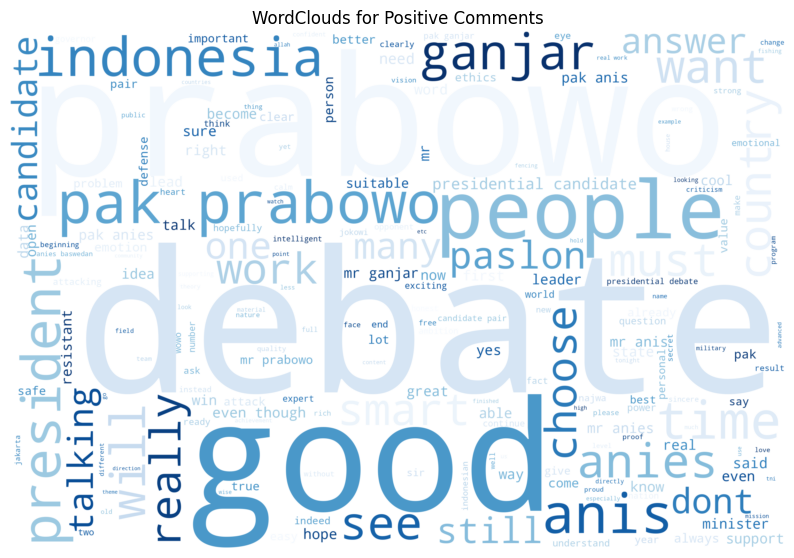

In [99]:
# Visualization wordclouds for positive comments
positive_comments = data[data['target'] == 'Positif']['translated']
wordcloud = WordCloud(background_color='white', width= 3000, height= 2000, colormap='Blues_r').generate(' '.join(positive_comments))
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("WordClouds for Positive Comments")
plt.axis("off")
plt.show()

## Neutral WordClouds

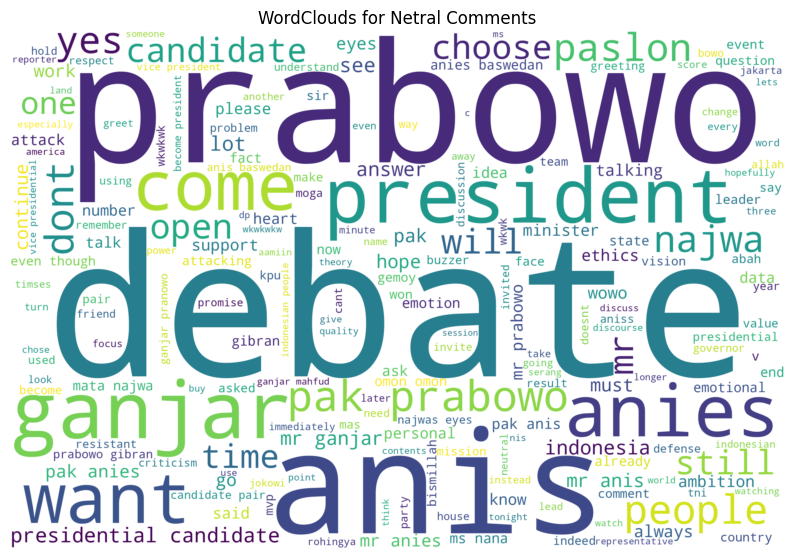

In [100]:
# Visualization wordclouds for netral comments
netral_comments = data[data['target'] == 'Netral']['translated']
wordcloud = WordCloud(background_color='white', width= 3000, height= 2000).generate(' '.join(netral_comments))
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("WordClouds for Netral Comments")
plt.axis("off")
plt.show()

## Negative WordClouds

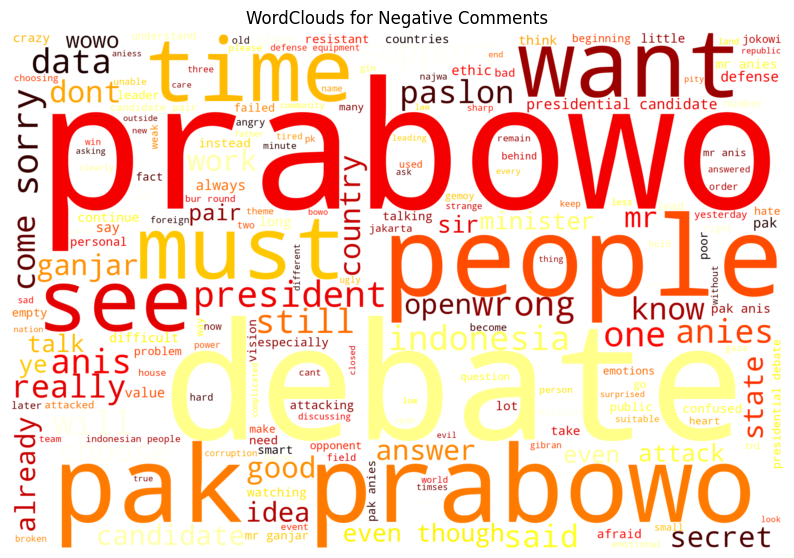

In [101]:
# Visualization wordclouds for negative comments
negative_comments = data[data['target'] == 'Negatif']['translated']
wordcloud = WordCloud(background_color='white', width= 3000, height= 2000, colormap='hot_r').generate(' '.join(negative_comments))
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("WordClouds for Negative Comments")
plt.axis("off")
plt.show()

# Modelling

## Datasets Splitting

In [25]:
# Split the data into features (X) and labels (y)
X = data['translated']
y = data['target']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [27]:
display(X_train.shape)
display(X_test.shape)

(2711,)

(302,)

In [28]:
vectorizer = TfidfVectorizer(ngram_range=(1,3), analyzer='char')

In [29]:
def evaluation(Y_test,Y_pred):
    acc = accuracy_score(Y_test,Y_pred)
    rcl = recall_score(Y_test,Y_pred,average = 'weighted')
    f1 = f1_score(Y_test,Y_pred,average = 'weighted')
    ps = precision_score(Y_test,Y_pred,average = 'weighted')
    metric_dict={
        'accuracy': round(acc,3),
        'recall': round(rcl,3),
        'F1 score': round(f1,3),
        'Precision score': round(ps,3)
    }
    return print(metric_dict)

## Logistic Regression

In [30]:
pipe_lr = pipeline.Pipeline([
    ('vectorizer', vectorizer),
    ('lr_clf', LogisticRegression())
])

In [31]:
%time pipe_lr.fit(X_train, y_train)

CPU times: user 1.54 s, sys: 1.18 s, total: 2.72 s
Wall time: 1.79 s


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer='char', ngram_range=(1, 3))),
                ('lr_clf', LogisticRegression())])

In [32]:
lr_predicted = pipe_lr.predict(X_test)

In [33]:
evaluation(y_test, lr_predicted)
accuracy_lr = round(accuracy_score(y_test, lr_predicted), 3)
print("Accuracy:", accuracy_lr)

{'accuracy': 0.738, 'recall': 0.738, 'F1 score': 0.703, 'Precision score': 0.744}
Accuracy: 0.738


## Multinomial Naive Bayes

In [34]:
pipe_mnb = pipeline.Pipeline([
    ('vectorizer', vectorizer),
    ('mnb_clf', MultinomialNB())
])

In [35]:
%time pipe_mnb.fit(X_train, y_train)

CPU times: user 426 ms, sys: 0 ns, total: 426 ms
Wall time: 429 ms


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer='char', ngram_range=(1, 3))),
                ('mnb_clf', MultinomialNB())])

In [36]:
mnb_predicted = pipe_mnb.predict(X_test)

In [37]:
evaluation(y_test, mnb_predicted)
accuracy_mnb = round(accuracy_score(y_test, mnb_predicted), 4)
print("Accuracy:", accuracy_mnb)

{'accuracy': 0.543, 'recall': 0.543, 'F1 score': 0.438, 'Precision score': 0.559}
Accuracy: 0.543


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Support Vector Machine

In [38]:
pipe_svc = pipeline.Pipeline([
    ('vectorizer', vectorizer),
    ('svc_clf', LinearSVC())
])

In [39]:
%time pipe_svc.fit(X_train, y_train)

CPU times: user 625 ms, sys: 0 ns, total: 625 ms
Wall time: 649 ms


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer='char', ngram_range=(1, 3))),
                ('svc_clf', LinearSVC())])

In [40]:
svc_predicted = pipe_svc.predict(X_test)

In [41]:
evaluation(y_test, svc_predicted)
accuracy_svc = round(accuracy_score(y_test, svc_predicted),3)
print("Accuracy:", accuracy_svc)

{'accuracy': 0.791, 'recall': 0.791, 'F1 score': 0.78, 'Precision score': 0.785}
Accuracy: 0.791


## Decision Tree

In [42]:
pipe_dt = pipeline.Pipeline([
    ('vectorizer', vectorizer),
    ('dt_clf', DecisionTreeClassifier())
])

In [43]:
%time pipe_dt.fit(X_train, y_train)

CPU times: user 2.16 s, sys: 0 ns, total: 2.16 s
Wall time: 2.69 s


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer='char', ngram_range=(1, 3))),
                ('dt_clf', DecisionTreeClassifier())])

In [44]:
dt_predicted = pipe_dt.predict(X_test)

In [45]:
evaluation(y_test, dt_predicted)
accuracy_dt = round(accuracy_score(y_test, dt_predicted),3)
print("Accuracy:", accuracy_dt)

{'accuracy': 0.589, 'recall': 0.589, 'F1 score': 0.593, 'Precision score': 0.597}
Accuracy: 0.589


## Random Forest

In [46]:
pipe_rf = pipeline.Pipeline([
    ('vectorizer', vectorizer),
    ('rf_clf', RandomForestClassifier())
])

In [47]:
%time pipe_rf.fit(X_train, y_train)

CPU times: user 3.86 s, sys: 1.04 ms, total: 3.86 s
Wall time: 3.87 s


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer='char', ngram_range=(1, 3))),
                ('rf_clf', RandomForestClassifier())])

In [48]:
rf_predicted = pipe_rf.predict(X_test)

In [49]:
evaluation(y_test, rf_predicted)
accuracy_rf = round(accuracy_score(y_test, rf_predicted),3)
print("Accuracy:", accuracy_rf)

{'accuracy': 0.662, 'recall': 0.662, 'F1 score': 0.62, 'Precision score': 0.714}
Accuracy: 0.662


## Multi-layer Perceptron

In [50]:
pipe_mlp = pipeline.Pipeline([
    ('vectorizer', vectorizer),
    ('mlp_clf', MLPClassifier())
])

In [51]:
%time pipe_mlp.fit(X_train, y_train)

CPU times: user 40.5 s, sys: 27.2 s, total: 1min 7s
Wall time: 57.8 s


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(analyzer='char', ngram_range=(1, 3))),
                ('mlp_clf', MLPClassifier())])

In [52]:
mlp_predicted = pipe_mlp.predict(X_test)

In [53]:
evaluation(y_test, mlp_predicted)
accuracy_mlp = round(accuracy_score(y_test, mlp_predicted),3)
print("Accuracy:", accuracy_mlp)

{'accuracy': 0.738, 'recall': 0.738, 'F1 score': 0.736, 'Precision score': 0.737}
Accuracy: 0.738


# Evaluation

In [54]:
model_comp = pd.DataFrame({
    'Model': ['LR', 'NB', 'SVM', 'DT', 'RF', 'MLP'],
    'Accuracy': [accuracy_lr*100, accuracy_mnb*100, accuracy_svc*100, accuracy_dt*100, accuracy_rf*100, accuracy_mlp*100]
    })

model_comp

,Model,Accuracy
0,LR,73.8
1,NB,54.3
2,SVM,79.1
3,DT,58.9
4,RF,66.2
5,MLP,73.8


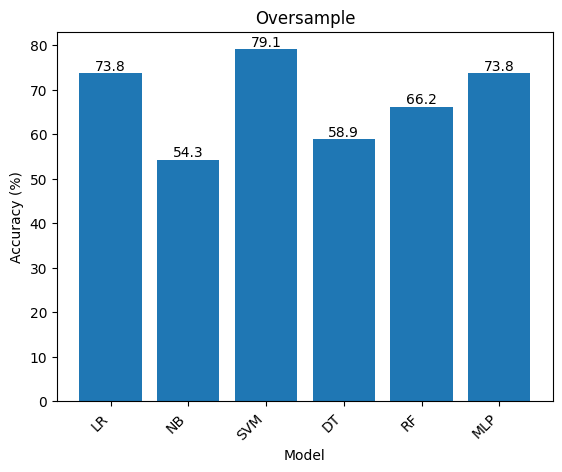

In [55]:
# Membuat bar plot dengan keterangan jumlah
fig, ax = plt.subplots()
bars = plt.bar(model_comp['Model'], model_comp['Accuracy'])
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Oversample')
plt.xticks(rotation=45, ha='right') # Untuk memutar label sumbu x agar lebih mudah dibaca
# Menambahkan keterangan jumlah di atas setiap bar
for bar in bars:
 yval = bar.get_height()
 plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
plt.show()

In [73]:
data_comment = list(data['translated'])
status = []

for i, txt in enumerate(data_comment):
    analysis = pipe_svc.predict([txt])[0]
    status.append(analysis)

In [74]:
data['predicted'] = status
data

<ipython-input-74-855cf3cdc3ee>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['predicted'] = status


,translated,target,predicted
0,why does najwas eyes not air anymore on tv eve...,Positif,Positif
1,about atikmk who passed the child the child so...,Netral,Netral
2,candidate for discourse speaking no evidence i...,Positif,Positif
3,salfok with the final session when reporters w...,Netral,Netral
4,ms nana started to look after talking like thi...,Netral,Netral
...,...,...,...
3046,greetings prabowo gibran wins one aminn,Positif,Netral
3047,this two candidate debate is very exciting,Positif,Positif
3048,bismillah,Netral,Netral
3049,forever no more amn,Negatif,Negatif


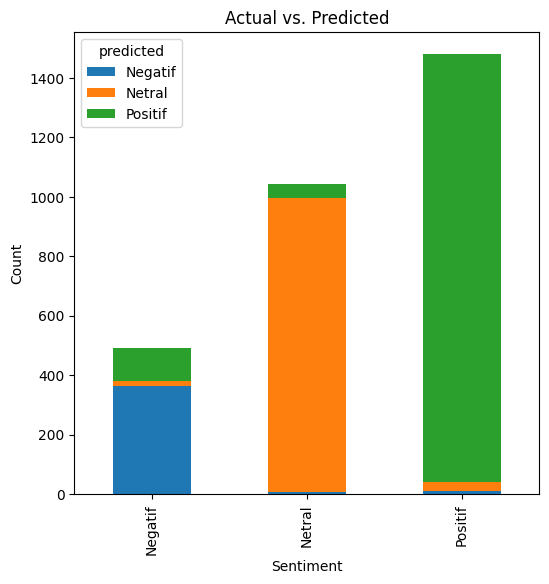

In [102]:
# Count the occurrences of each combination of 'target' and 'predicted'
confusion_matrix = pd.crosstab(data['target'], data['predicted'])

# Plotting the bar chart
confusion_matrix.plot(kind='bar', stacked=True, figsize=(6, 6))
plt.title('Actual vs. Predicted')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [84]:
data_eval = [tuple(x) for x in data.to_records(index=False)]

for n in data_eval:
    if n[1] != n[2]:
        print(f'Text : {n[0]}\nActual: {n[1]}\nPredicted: {n[2]} \n')

Text : why does mr anies continue to discuss ethics if you realize it is very dangerous if the one who wins the brutal deers shadow later the country next year is right pak anies see to the people of the original character
Actual: Negatif
Predicted: Positif 

Text : pak anis really knows the weak pak prabowo so he continues to attack mr prabowo i am i pak prabowo is not good at the word but he works real now the debate is seen the theory and the question and answer is not clear but pak prabowo really cant talk quickly especially this time so it is difficult to be clear i go to if this candidate is invited to najwas eyes clearly without any time
Actual: Negatif
Predicted: Positif 

Text : i am surprised that there are still people who support anis even though all those who are talking about the false program does not make sense how come it is still not smart our free bbm program does not make sense of the city of tara jakartamotomupek the capital city has not completed it in jakarta etc

# Reference
- https://youtu.be/nk6VrUZBG7o?si=m9qE0tt7_AdhfeNL
- https://youtu.be/PiOmqPUbYV0?si=qoLB0iA35PiVjjaC
- https://github.com/m-nahrowi/SentimenAnalisisDebatCapresiD/